<a href="https://colab.research.google.com/github/alighazal/R-Deep/blob/main/R_Deep_Final_Milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-Deep
An indoor localiztion systems based on wifi singals that uses deep learning techniques. this system proved to be robust against changes in the envrioment, and can be used to localize both android and apple phones. that is, it can predict the location using either a vector of RSS readings from the enviroment or One Access Point (as is the case with iphones).

## Dependencies

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN, GRU
from keras.models import Model, Sequential

print(tf.__version__)

2.4.1


In [ ]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=5, suppress=True)

## Uploading data and unziping files

[Dataset link](https://www.kaggle.com/hiro5299834/indoor-navigation-and-location-wifi-features)

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


### first time only when you are loading the drive

In [ ]:
!mkdir "/drive/MyDrive/location datasets/wifi_features"

In [ ]:
!unzip "./MyDrive/location datasets/archive.zip" -d  "/drive/MyDrive/location datasets/wifi_features"

## importing data

In [ ]:
ds =  pd.read_csv("/drive/MyDrive/location datasets/wifi_features/wifi_features/train/5d27075f03f801723c2e360f_1000_train.csv")

In [ ]:
ds

In [ ]:
## removing meaningless column
ds.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
ds[['x','y','f']].describe()

In [ ]:
ds[['x','y','f']].hist()

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(ds['x'], ds['y'])
plt.show()

In [ ]:
## here for sake of simplicity i decided to work with one floor (floor zero (0))
ds_f0 = ds[ds['f'] == 0]

In [ ]:
features = ds_f0.drop(['x','y','f','path'], axis=1)

In [ ]:
labels = ds_f0[['x','y']]

## Normalizing the data using sklean

> only use one of the following scaling methods. after experimentation, min-max produced better results.

In [ ]:
#option 1
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [ ]:
#option 2
normalizer = Normalizer()
features = normalizer.fit_transform(features)

In [ ]:
features

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.9589 ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.9589 ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.9589 ],
       ...,
       [0.     , 0.99466, 0.     , ..., 0.     , 0.     , 0.97576],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.97787],
       [0.     , 0.98292, 0.     , ..., 0.     , 0.     , 0.97682]])

In [ ]:
features.shape

(6549, 1805)

## splitting the data 60% train 40% validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42, shuffle=True)

## utility functions

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)


In [ ]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [ ]:
def draw_cdf(array_of_predicted_true_readings, title, max_x = 50):
  errors_of_models = []
  for readings_model in array_of_predicted_true_readings:
    errors_of_models.append(calc_error(np.array(readings_model[0]), np.array(readings_model[1])))
  
  legends = []
  for readings_model in array_of_predicted_true_readings:
    legends.append(readings_model[2])

  cumulatives = []
  bases = []
  for error_of_model in errors_of_models:
    values, base = np.histogram(error_of_model,50)
    values_prob = values / sum(values)
    bases.append(base)
    cumulatives.append(np.cumsum(values_prob))

  plt.figure(figsize=(8, 6), dpi=80)

  for i, cumulative in enumerate(cumulatives):
    plt.plot(bases[i][:-1], cumulative) 

  plt.title(title)
  plt.xlim((0, max_x))
  plt.xlabel('distance (meter)')
  plt.ylabel('probability')
  plt.legend(legends)
  plt.show()

### drawing error

In [ ]:
# error function
def euclidean_distance(p, q):
    dist = 0.0
    # your code for euclidean distance calculation is here
    squared_sum = 0
    for i in range(len(p)):
        squared_sum += (p[i] - q[i])**2
    
    dist = (squared_sum)**(1/2)
    return dist

In [ ]:
# calculate the error
def calc_error (predicted_locs, test_locs):
  error = []
  for index, location in enumerate (predicted_locs):
    error.append(euclidean_distance(location, test_locs[index]))
  return (error)

### leaving only max AP

In [ ]:
def leave_only_max_reading(ds):
  num_aps = len(ds[0])
  rss_max_ap = []
  for rss_point in np.array(ds):
    new_rss_point = np.zeros(num_aps)
    new_rss_point[np.argmax(rss_point)] = np.max(rss_point)
    rss_max_ap.append (new_rss_point)

  return np.array(rss_max_ap)

### tower dropping

In [ ]:
def apply_tower_dropping_noise(data, drop_ratio = .1):
  tower_dropped_data = []
  for row in data:
    non_zeros_index = np.where( row > 0 )
    num_droped_points = round (drop_ratio * len(non_zeros_index[0]))
    index_dropped_points = random.sample(list(non_zeros_index[0]), num_droped_points)
    new_row =  row.copy()
    for index in index_dropped_points:
      new_row[index] = 0
    tower_dropped_data.append(new_row)
  return np.array(tower_dropped_data)

### adding white noise

In [ ]:
def add_white_noise(data, noise_ratio = 0.1):
  noisy_data = []
  for row in data:
    non_zeros_index = np.where( row > 0 )
    new_row =  row.copy()
    for i, index in enumerate (non_zeros_index):
      new_row[index] = row[index] + np.random.rand() * noise_ratio  * -1**i
    noisy_data.append(new_row)
  return np.array(noisy_data)

## Building the model

### deep dense layers with different architctures:

In [ ]:
def baseline_model(dim):
	# create model
	model = keras.Sequential()
	model.add(keras.layers.Dense(300, input_dim=dim, kernel_initializer='normal', activation='tanh'))
	model.add(keras.layers.Dense(300, input_dim=dim, kernel_initializer='normal', activation='tanh'))
	model.add(keras.layers.Dense(300, input_dim=dim, kernel_initializer='normal', activation='tanh'))
	model.add(keras.layers.Dense(2, kernel_initializer='normal'))
	# Compile model
	model.compile( loss = 'mse', metrics='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
	return model

In [ ]:
[rows, cols] = X_train.shape

In [ ]:
dnn = baseline_model(cols)

In [ ]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               541800    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 723,002
Trainable params: 723,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=2, epochs=200,
    callbacks =[earlystopping]
    )

In [ ]:
plot_loss(history)

In [ ]:
test_results = dnn.evaluate(
    X_test,
    y_test, verbose=0)

In [ ]:
predicted_dnn = dnn.predict(X_test)

In [ ]:
test_results

[19.097383499145508, 2.948732614517212]

## Experimenting with autoencoders:

https://towardsdatascience.com/autoencoders-bits-and-bytes-of-deep-learning-eaba376f23ad

In [ ]:
encoding_dim = 32

input_vec = Input(shape=(cols,))

encoded = Dense(512, kernel_initializer='normal', activation='relu')(input_vec)
encoded = Dense(256, kernel_initializer='normal',  activation='relu')(encoded)

encoded = Dense(128, kernel_initializer='normal',  activation='relu')(encoded)

decoded = Dense(256, kernel_initializer='normal', activation='relu')(encoded)
decoded = Dense(512, kernel_initializer='normal',  activation='relu')(decoded)

decoded = Dense(cols, activation='relu')(decoded)


autoencoder = Model(input_vec, decoded)

encoder = Model(input_vec, encoded)

autoencoder.compile(optimizer='adam', metrics= ['mean_absolute_error'], loss='mse')


In [ ]:
autoencoder.summary()

In [ ]:
history_autoencoder = autoencoder.fit(
                            X_train, X_train,
                            validation_split=0.2,
                            verbose=2, epochs=150,
                            )

In [ ]:
plot_loss(history_autoencoder)

In [ ]:
test_resutls_ae = autoencoder.evaluate( X_test,
    X_test, verbose=0)

In [ ]:
test_resutls_ae

[0.013285561464726925, 0.02419554442167282]

In [ ]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

### model to train the encoded input

In [ ]:
dnn_ae = baseline_model(128)

In [ ]:
dnn_ae.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 300)               38700     
_________________________________________________________________
dense_46 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_47 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 602       
Total params: 219,902
Trainable params: 219,902
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_dnn_ae = dnn_ae.fit(
                      X_train_encoded, y_train,
                      validation_split=0.2,
                      verbose=1, epochs=200
                  )

In [ ]:
plot_loss(history_dnn_ae)

In [ ]:
dnn_ae.evaluate(X_test_encoded, y_test)

82/82 [==============================] - 0s 2ms/step - loss: 18.8085 - mean_absolute_error: 2.7619


[18.80852699279785, 2.761897563934326]

In [ ]:
predicted_dnn_ae = dnn_ae.predict(X_test_encoded)

### Testing on Noisy Data

In [ ]:
dnn_ae.evaluate(encoder.predict(apply_tower_dropping_noise(X_test, 0.5)), y_test)

In [ ]:
dnn_ae.evaluate(encoder.predict(add_white_noise(X_test, 0.5)), y_test)

## Miscellaneous

In [ ]:
X_train_with_white_noise = add_white_noise(X_train, .1)

In [ ]:
X_train_with_tower_dropping = apply_tower_dropping_noise(X_train, .5)

In [ ]:
X_train_with_white_noise = np.concatenate((X_train_with_white_noise , X_train), axis=0)
X_train_with_tower_dropping = np.concatenate(( X_train_with_tower_dropping , X_train), axis=0)

In [ ]:
y_train_with_tower_dropping = np.concatenate(( np.array(y_train), np.array(y_train), np.array(y_train)), axis=0)
y_train_with_white_noise = np.concatenate(( np.array(y_train), np.array(y_train), np.array(y_train)), axis=0)

## Gridding

In [ ]:
labels = ds_f0[['x','y']]

In [ ]:
GRID_SIZE = 1

In [ ]:
labels['row'] =  np.round(labels['y'] / GRID_SIZE)

In [ ]:
labels['cols'] =  np.round(labels['x'] / GRID_SIZE)

In [ ]:
num_cols =  max(labels['row']) - min(labels['row'])

In [ ]:
labels['grid'] = (labels['row'] * num_cols + labels['cols'])

In [ ]:
labels = labels.astype({'grid': 'int32'})
for i in range(1,max(labels['grid'])+1):
  labels[f'grid_{i}'] = labels['grid'] == i

In [ ]:
grid_ids = set(labels['grid'])

In [ ]:
grid_positions = {}
for grid_id in grid_ids:
  size = len(labels[labels['grid'] == grid_id]['x'])
  x = sum(labels[labels['grid'] == grid_id]['x'])/ size
  y = sum(labels[labels['grid'] == grid_id]['y'])/ size
  grid_positions[grid_id] = [x, y]

In [ ]:
grid_positions

## Deep learning model for gridded output positions

In [ ]:
def dnn_clf(dim):
  # create model
  model = keras.Sequential()
  model.add(keras.layers.Dense(100, input_dim=dim, kernel_initializer='normal', activation='tanh'))
  model.add(keras.layers.Dense(100, input_dim=dim, kernel_initializer='normal', activation='tanh'))
  model.add(keras.layers.Dense(max(labels['grid']), kernel_initializer='normal', activation='softmax'))
  model.add(keras.layers.Dropout(.2))
  # Compile model
  model.compile( loss = 'categorical_crossentropy', metrics='accuracy',optimizer='adam')
  return model

In [ ]:
dnn = dnn_clf(cols)

In [ ]:
dnn.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42, shuffle=True)

In [ ]:
y_train_positions = y_train[['x', 'y']]
y_test_positions = y_test[['x', 'y']]

In [ ]:
y_train.drop(['x','y','grid', 'row', 'cols'], inplace=True, axis=1)

In [ ]:
y_test.drop(['x','y','grid', 'row', 'cols'], inplace=True, axis=1)

In [ ]:
history = dnn.fit(
    X_train, y_train,
    validation_split=0.3,
    verbose=2, epochs=100
    )

In [ ]:
plot_loss(history)

In [ ]:
test_results = dnn.evaluate(
    X_test,
    y_test, verbose=0)

In [ ]:
test_results

In [ ]:
predictions = dnn.predict(X_test)

In [ ]:
predicted_grid_label = []
for prediction in predictions:
  predicted_grid_label.append(np.argmax(prediction));

In [ ]:
predicted_positions_x = []
predicted_positions_y = []
for p_g in predicted_grid_label:
  if (p_g not in grid_positions):
    p_g = p_g-1
    if (p_g not in grid_positions):
      p_g = p_g+2
  predicted_positions_x.append(grid_positions[p_g][0])
  predicted_positions_y.append(grid_positions[p_g][1])

In [ ]:
predicted_positons = pd.DataFrame()
predicted_positons['x'] = predicted_positions_x;
predicted_positons['y'] = predicted_positions_y;

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_positions, predicted_positons)

2.7090949881133675

## Effect of using one AP
* normal model 
* model trained on Maximum AP
* RNN

In [ ]:
X_test_max_AP = leave_only_max_reading(X_test)

### Model training (complete data vs one AP prediction):

In [ ]:
dnn_one_ap_comp_train_data = baseline_model(cols)

In [ ]:
dnn_one_ap_comp_train_data.summary()

In [ ]:
history = dnn_one_ap_comp_train_data.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=2, epochs=100,
    )

In [ ]:
plot_loss(history)

In [ ]:
test_results = dnn_one_ap_comp_train_data.evaluate(
    X_test_max_AP,
    y_test, verbose=0)

In [ ]:
test_results

_____________________________________

In [ ]:
dnn_1ap_test_1ap_train = baseline_model(cols)

In [ ]:
dnn_1ap_test_1ap_train.summary()

In [ ]:
history = dnn_1ap_test_1ap_train.fit(
    np.concatenate((X_train, leave_only_max_reading(X_train))),
    np.concatenate ((y_train, y_train)),
    validation_split=0.2,
    verbose=2, epochs=100,
    )

In [ ]:
plot_loss(history)

In [ ]:
test_results = dnn_1ap_test_1ap_train.evaluate(
    X_test_max_AP,
    y_test, verbose=0)

In [ ]:
test_results

[425.2216491699219, 11.696505546569824]

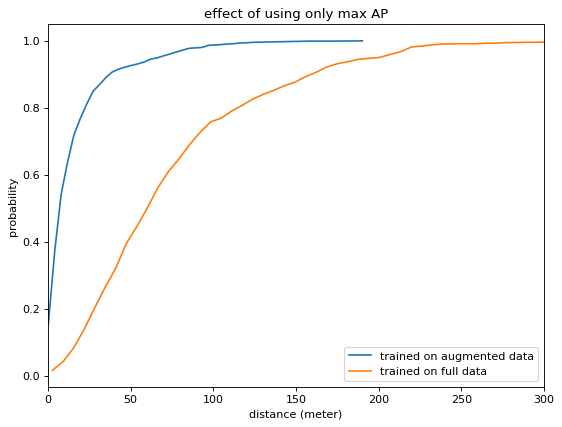

In [ ]:
draw_cdf([[ np.array(y_test), np.array(dnn_1ap_test_1ap_train.predict(X_test_max_AP), dtype=int) , 'trained on augmented data'],
          [ np.array(y_test), np.array(dnn_one_ap_comp_train_data.predict(X_test_max_AP), dtype=int) , 'trained on full data']], 'effect of using only max AP', 300)

### Models trained on trace generator data

#### Trace Generator

In [ ]:
def generate_random_walk(finger_print):

  start_index = np.random.randint(0,len(finger_print)) 
  start = finger_print.iloc[start_index]

  walking_seq = []
  current = start.copy()
  for i in range(500):
    nxt_pos_x = current['x'] + (-1)**(np.round(np.random.rand())) + STEP_SIZE * np.round(np.random.rand())
    nxt_pos_y = current['y'] + (-1)**(np.round(np.random.rand())) + STEP_SIZE * np.round(np.random.rand())

    if (nxt_pos_x >=  min_x and nxt_pos_x <= max_x and 
        nxt_pos_y >=  min_y and nxt_pos_y <= max_y):
      
      walking_seq.append ([nxt_pos_x, nxt_pos_y])
      current['x'] = nxt_pos_x
      current['y'] = nxt_pos_y
    else:
      break

  print (len(walking_seq))
  return walking_seq

In [ ]:
def generate_seq_random_walks(ds, min_size=50, seq_size=10_000):
  random_walks = []
  while (len(random_walks) < 20_000):
    single_walk = generate_random_walk(ds)
    if (len(single_walk) > 50):
      random_walks += single_walk
  
  rand_walk_x = np.array(random_walks)[:,0]
  rand_walk_y = np.array(random_walks)[:,1]
  
  positions = pd.DataFrame()
  positions['x'] = rand_walk_x
  positions['y'] = rand_walk_y

  return positions

In [ ]:
STEP_SIZE = 2

max_y = np.percentile(y_train['y'], 95)
max_x = np.percentile(y_train['x'], 95)

min_y = np.percentile(y_train['y'], 5)
min_x = np.percentile(y_train['x'], 5)

print (min_y, max_y)
print (min_x, max_x)

In [ ]:
positions = generate_seq_random_walks(y_train)

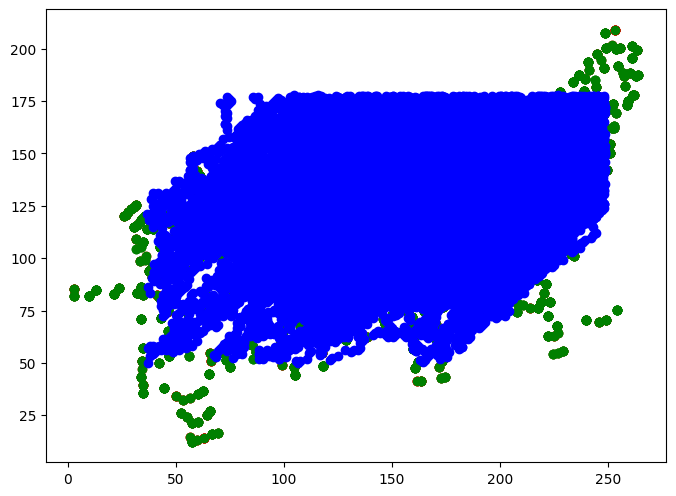

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(y_test['x'], y_test['y'], color= 'r') 
plt.scatter(y_train['x'], y_train['y'], color= 'g') 
plt.scatter(positions['x'], positions['y'], color= 'b') 
plt.show()

In [ ]:
def generate_rss(walk, X,y):
  knn = KNeighborsRegressor(n_neighbors=1)
  knn.fit(y,X ) # here i am trying to get the rss reading from the position
  rss = knn.predict(walk)
  rss_max_ap = leave_only_max_reading(rss)
  return rss_max_ap

In [ ]:
rss = generate_rss(positions, X_train, y_train)
rss

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
positions = np.array(positions)
X_train, X_test, y_train, y_test = train_test_split(rss, positions, test_size=0.8, random_state=42)

In [ ]:
X_train_r = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_r = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train_r = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test_r = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

#### RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(300, input_shape=X_train_r.shape[1:], activation='tanh', return_sequences=True))
model.add(SimpleRNN(300, input_shape=X_train_r.shape[1:], activation='tanh', return_sequences=True))
model.add(SimpleRNN(300, input_shape=X_train_r.shape[1:], activation='tanh'))
model.add(Dense(300, activation='tanh'))
model.add(Dense(150, activation='tanh'))
model.add(Dense(2))

model.compile( loss = 'mse', metrics='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 1, 300)            631800    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 1, 300)            180300    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 300)               180300    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 302       
Total params: 1,128,152
Trainable params: 1,128,152
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(X_train_r,y_train_r,
            validation_split=0.2,
            verbose=1, epochs=50)

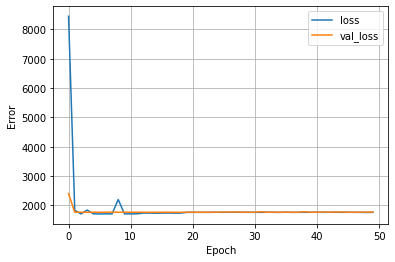

In [ ]:
plot_loss(history)

In [ ]:
model.evaluate(X_test_r, y_test_r)

In [ ]:
model.predict(X_test_r)

In [ ]:
history = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=2, epochs=200,
    callbacks =[earlystopping]
    )

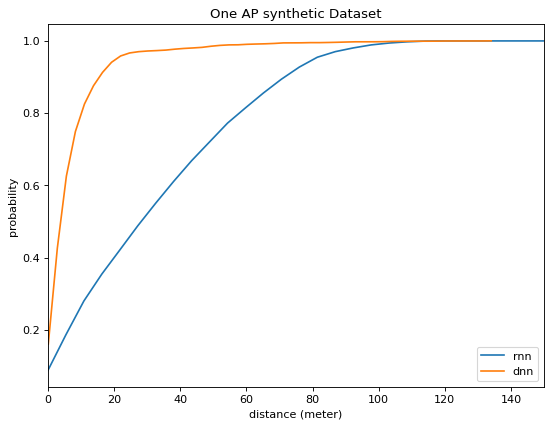

In [ ]:
draw_cdf([[np.array(y_test_r), np.array(model.predict(X_test_r)), 'rnn'],
          [np.array(y_test), np.array(dnn.predict(X_test)), 'dnn']]
         , 'One AP synthetic Dataset', 150)

## Evaluation

#### Different data augmnetation techniques
* tower dropping
* white noise
* trace generator

In [ ]:
dnn_original = baseline_model(cols)
dnn_tower_dropping = baseline_model(cols)
dnn_white_noise = baseline_model(cols)
dnn_noise_and_dropped_tower = baseline_model(cols)
dnn_trace_generator = baseline_model(cols)

In [ ]:
history_original = dnn_original.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=2, epochs=100,
    )

In [ ]:
history_white_noise = dnn_white_noise.fit(
    np.concatenate((X_train, X_train_with_white_noise)),
    np.concatenate((y_train, y_train)),
    validation_split=0.2,
    verbose=2, epochs=100,
    )

In [ ]:
history_tower_dropping = dnn_tower_dropping.fit(
    np.concatenate((X_train, X_train_with_tower_dropping)),
    np.concatenate((y_train, y_train)),
    validation_split=0.2,
    verbose=2, epochs=100,
    )

In [ ]:
history_noise_and_dropped_tower = dnn_noise_and_dropped_tower.fit(
    np.concatenate((X_train, X_train_with_tower_dropping, X_train_with_white_noise)),
    np.concatenate((y_train, y_train, y_train)),
    validation_split=0.2,
    verbose=2, epochs=100,
    )

In [ ]:
predictions_original = dnn_original.predict(X_test)
predictions_white_noise = dnn_white_noise.predict(X_test)
predictions_tower_dropping = dnn_tower_dropping.predict(X_test)
predictions_noise_and_dropped_tower = dnn_noise_and_dropped_tower.predict(X_test)

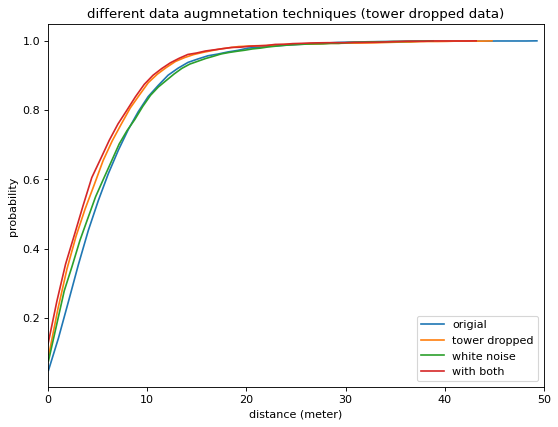

In [ ]:
draw_cdf([[np.array(y_test), np.array(dnn_original.predict(apply_tower_dropping_noise(X_test,.3))), 'origial'],
          [np.array(y_test), np.array(dnn_tower_dropping.predict(apply_tower_dropping_noise(X_test,.3))), 'tower dropped'],
          [np.array(y_test), np.array(dnn_white_noise.predict(apply_tower_dropping_noise(X_test,.3))), 'white noise'],
          [np.array(y_test), np.array(dnn_noise_and_dropped_tower.predict(apply_tower_dropping_noise(X_test,.3))), 'with both']],
         'different data augmnetation techniques (tower dropped data)')

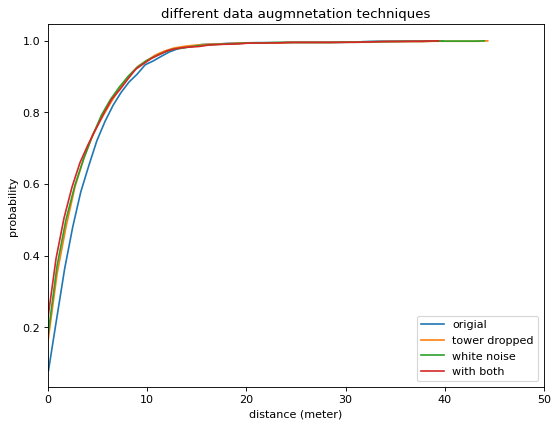

In [ ]:
draw_cdf([[np.array(y_test), np.array(predictions_original), 'origial'],
          [np.array(y_test), np.array(predictions_tower_dropping), 'tower dropped'],
          [np.array(y_test), np.array(predictions_white_noise), 'white noise'],
          [np.array(y_test), np.array(predictions_noise_and_dropped_tower), 'with both']],
         'different data augmnetation techniques')

#### Perfomance compared to:
* decision trees
* random forests
* KNN - 1 
* KNN - 3
* linear regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn1 = KNeighborsRegressor(n_neighbors=1, n_jobs = 3 )

knn1.fit(X_train, y_train)

In [ ]:
y_predict_knn1 = knn1.predict(X_test)

______________________________

In [ ]:
knn3 = KNeighborsRegressor(n_neighbors=3, n_jobs = 3 )

knn3.fit(X_train, y_train)

In [ ]:
y_predict_knn3 = knn3.predict(X_test)

_____________________

In [ ]:
from sklearn.ensemble import RandomForestRegressor

ran_x = RandomForestRegressor( random_state=0, n_jobs = 3 )
ran_y = RandomForestRegressor( random_state=0, n_jobs = 3 )

ran_x.fit(X_train, y_train['x'])
ran_y.fit(X_train, y_train['y'])

In [ ]:
y_predict_ran_x = ran_x.predict(X_test)
y_predict_ran_y = ran_y.predict(X_test)

In [ ]:
random_forest_predictions = pd.DataFrame()
random_forest_predictions['x'] = y_predict_ran_x
random_forest_predictions['y'] = y_predict_ran_y

________

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X_train, y_train)

In [ ]:
y_predict_lin = reg.predict(X_test)

_______________

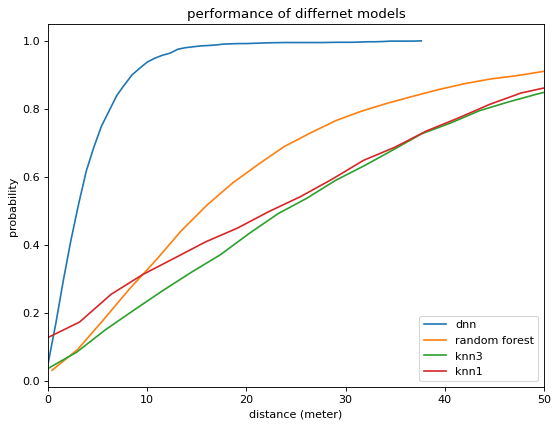

In [ ]:
draw_cdf([
          [np.array(y_test), np.array(predicted_dnn), 'dnn'],
          [np.array(y_test), np.array(random_forest_predictions), 'random forest'],
          [np.array(y_test), np.array(y_predict_knn3), 'knn3'],
          [np.array(y_test), np.array(y_predict_knn1), 'knn1'],
          ],
         'performance of differnet models', 50)

________

## DEMO